In [1]:
!rm -r sample_data
!pip install googledrivedownloader

rm: cannot remove 'sample_data': No such file or directory


In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='17HQj_24Kh3C2bFkiU2gLOnemaNZ_y44v',
                                    dest_path='./data.zip',
                                    unzip=True)

In [3]:
!ls -l

total 38304
drwxr-xr-x 4 root root     4096 Mar 30 15:22 dataset
-rw-r--r-- 1 root root 39218589 Mar 30 15:22 data.zip


In [4]:
%tensorflow_version 1.x
from __future__ import print_function


TensorFlow 1.x selected.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from skimage import io
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions


In [0]:
dataset = 'dataset'

In [0]:
INIT_LR = 1e-3
EPOCHS = 40
BS = 8

In [0]:
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	data.append(image)
	labels.append(label)

In [0]:

data = np.array(data) / 255.0
labels = np.array(labels)

# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [12]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [0]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [17]:
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 8s 725ms/step - loss: 0.7553 - acc: 0.6098 - val_loss: 0.4369 - val_acc: 0.8696
Epoch 2/40
11/11 [==============================] - 1s 85ms/step - loss: 0.3877 - acc: 0.8780 - val_loss: 0.4732 - val_acc: 0.8696
Epoch 3/40
11/11 [==============================] - 1s 94ms/step - loss: 0.4043 - acc: 0.8977 - val_loss: 0.4253 - val_acc: 0.8696
Epoch 4/40
11/11 [==============================] - 1s 83ms/step - loss: 0.4750 - acc: 0.8659 - val_loss: 0.3587 - val_acc: 0.8696
Epoch 5/40
11/11 [==============================] - 1s 82ms/step - loss: 0.3521 - acc: 0.8659 - val_loss: 0.3435 - val_acc: 0.8696
Epoch 6/40
11/11 [==============================] - 1s 81ms/step - loss: 0.3765 - acc: 0.8421 - val_loss: 0.3306 - val_acc: 0.8696
Epoch 7/40
11/11 [==============================] - 1s 94ms/step - loss: 0.2833 - acc: 0.9205 - val_loss: 0.3264 - val_

In [0]:
predIdxs = model.predict(testX, batch_size=BS)

In [19]:
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.91      1.00      0.95        20
      normal       1.00      0.33      0.50         3

    accuracy                           0.91        23
   macro avg       0.95      0.67      0.73        23
weighted avg       0.92      0.91      0.89        23



In [20]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[20  0]
 [ 2  1]]
acc: 0.9130
sensitivity: 1.0000
specificity: 0.3333


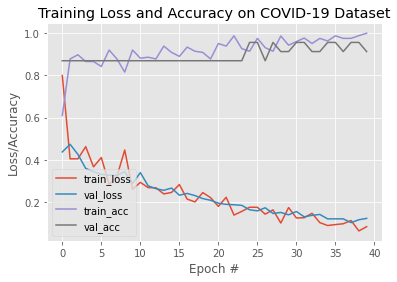

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')

In [0]:
def gradcam_from_img_url(url):
  obj = cv2.imread(url)
  obj = cv2.resize(obj, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = img_to_array(obj)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("block5_conv3")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (obj.shape[1], obj.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(obj, 0.5, heatmap, 0.5, 0)
  obj = cv2.resize(obj, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
  superimposed_img = cv2.resize(superimposed_img, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)

  cv2_imshow( obj)
  cv2_imshow(superimposed_img)


0


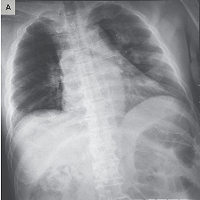

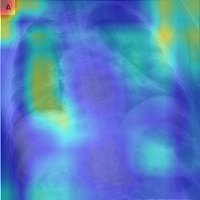

In [23]:
gradcam_from_img_url(dataset+'/covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg')

0


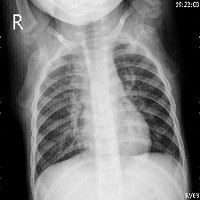

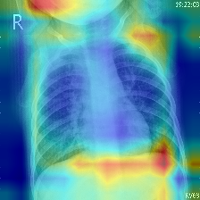

In [24]:
gradcam_from_img_url(dataset+'/normal/person1252_virus_2124.jpeg')

In [0]:
model.save('covid_detector.h5')